**Name:** Owulu amarachukwu emmanuella
**Student Id** : 8923561

### **Importing Libraries**

In [73]:
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array


### **Defining the Path to the Dataset Directory**

In [7]:
data_folder = pathlib.Path('../data/kaggle_dogs_vs_cats_small')

### **Loading and Preparing Image Datasets for Training, Validation, and Testing**

In [74]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [9]:
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

### **Inspecting the Shape of a Batch from the Training Dataset**

In [10]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [11]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0])>

### **Displaying the First Image from a Training Data Batch**

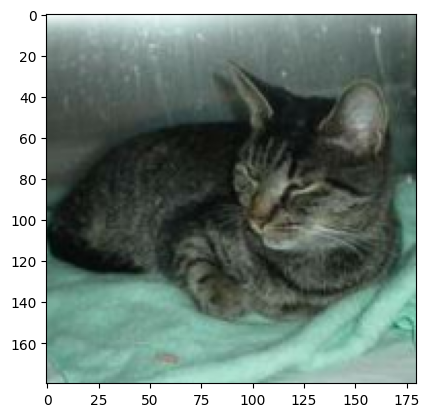

In [12]:
# import imshow
import matplotlib.pyplot as plt

plt.imshow(data_batch[0].numpy().astype("uint8"))

### **Explore the data**

In [80]:
# Dataset Overview
print(f"Training samples: {len(train_dataset.file_paths)}")
print(f"Validation samples: {len(validation_dataset.file_paths)}")
print(f"Test samples: {len(test_dataset.file_paths)}")
print(f"Image shape: {train_dataset.element_spec[0].shape[1:]}")
print(f"Classes: {train_dataset.class_names}")


Training samples: 2000
Validation samples: 1000
Test samples: 2000
Image shape: (180, 180, 3)
Classes: ['cat', 'dog']


### **Class Distribution Analysis**

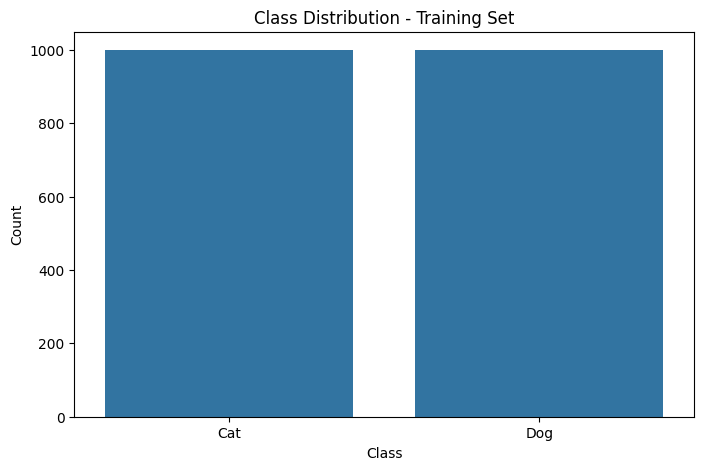

Training Set - Cats: 1000, Dogs: 1000
Training Set - Class ratio: 1.00:1


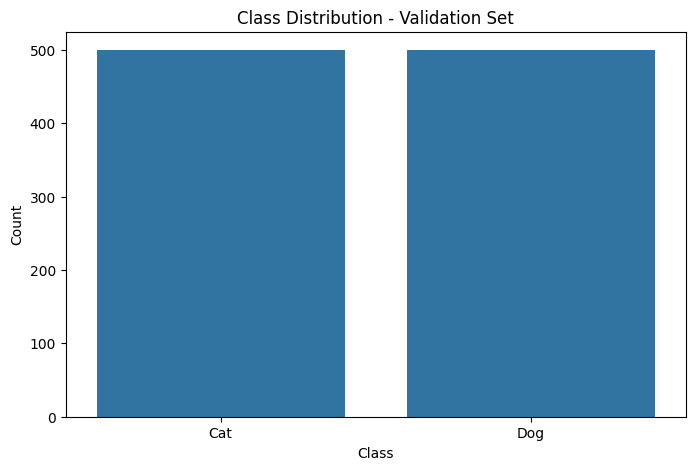

Validation Set - Cats: 500, Dogs: 500
Validation Set - Class ratio: 1.00:1


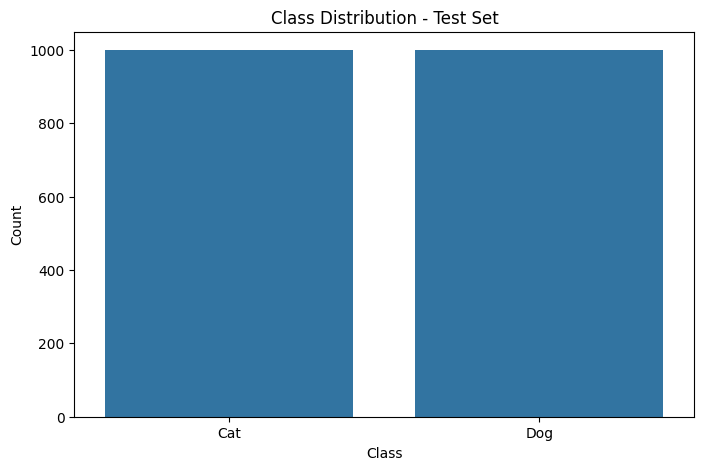

Test Set - Cats: 1000, Dogs: 1000
Test Set - Class ratio: 1.00:1


In [67]:
def plot_class_distribution(dataset, title):
    labels = []

    # Loop through the dataset and collect all labels
    for _, batch_labels in dataset:
        labels.extend(batch_labels.numpy())
    
     # Plot the count of each class using seaborn library
    plt.figure(figsize=(8, 5))
    sns.countplot(x=labels)
    plt.title(f'Class Distribution - {title}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    # Replace 0 and 1 with actual class names
    plt.xticks(ticks=[0, 1], labels=['Cat', 'Dog'])
    plt.show()
    
    # Count number of cats and dogs
    cat_count = sum(1 for label in labels if label == 0)
    dog_count = sum(1 for label in labels if label == 1)
    
    print(f"{title} - Cats: {cat_count}, Dogs: {dog_count}")
    print(f"{title} - Class ratio: {cat_count/dog_count:.2f}:1")

plot_class_distribution(train_dataset, "Training Set")
plot_class_distribution(validation_dataset, "Validation Set")
plot_class_distribution(test_dataset, "Test Set")



### **Image Sample Visualization**


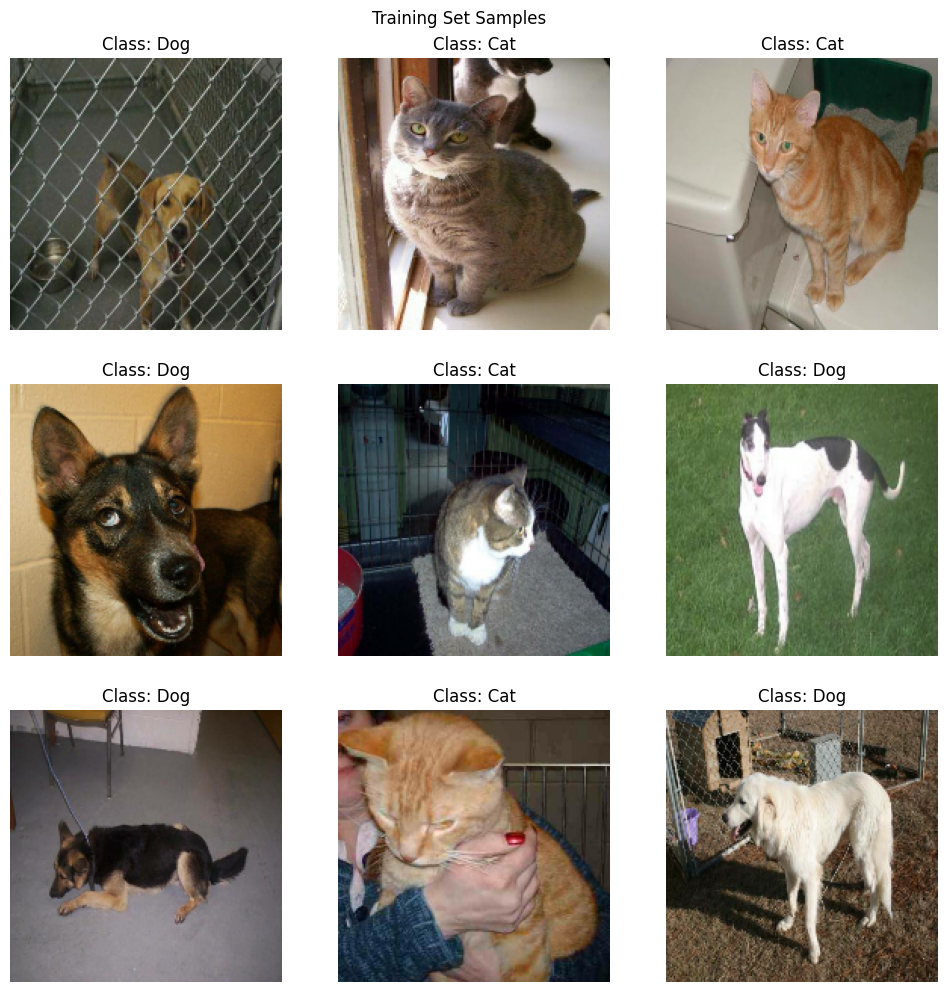

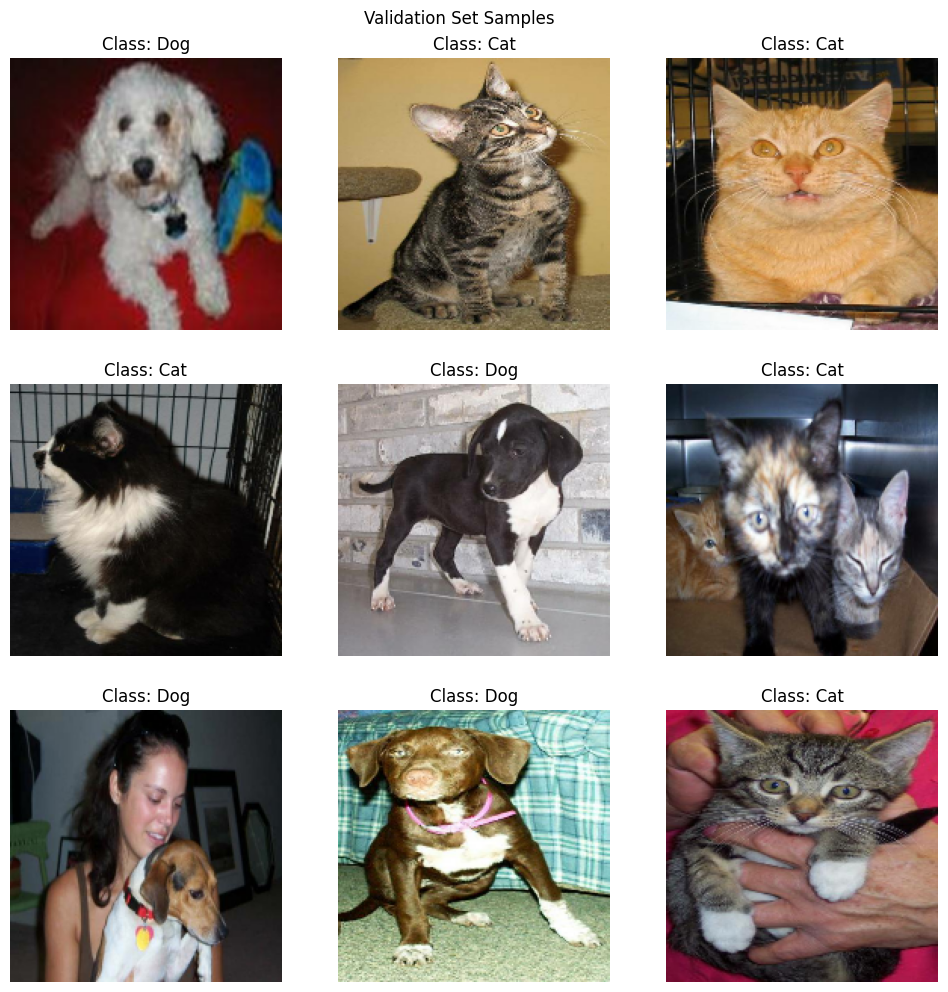

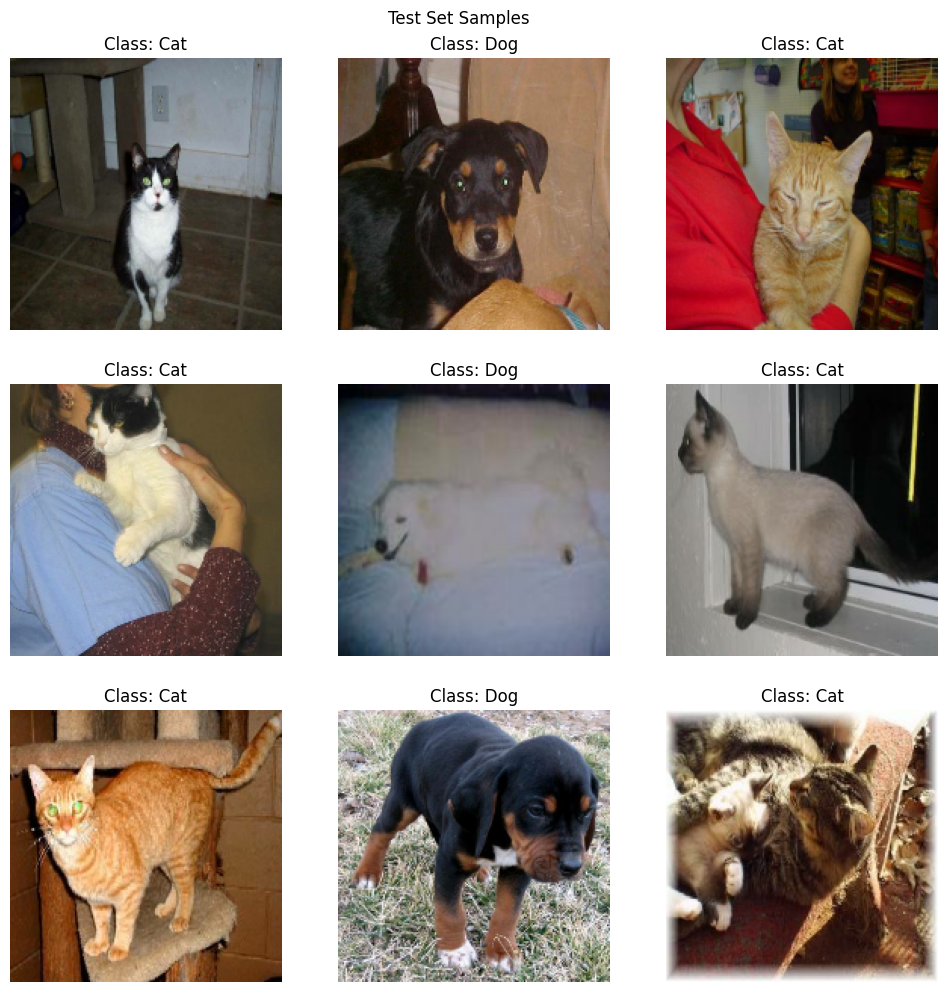

In [ ]:
def plot_sample_images(dataset, title, n=9):
    
    plt.figure(figsize=(12, 12))

    # Taking  one batch from the dataset
    for images, labels in dataset.take(1):
        # Loop through up to number of n images in the batch
        for i in range(min(n, len(images))):
              # Arrange images in a 3x3 grid
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))  # Display the image
            plt.title(f"Class: {'Dog' if labels[i] else 'Cat'}")
            plt.axis("off")
    plt.suptitle(title, y=0.92)
    plt.show()

plot_sample_images(train_dataset, "Training Set Samples")
plot_sample_images(validation_dataset, "Validation Set Samples")
plot_sample_images(test_dataset, "Test Set Samples")


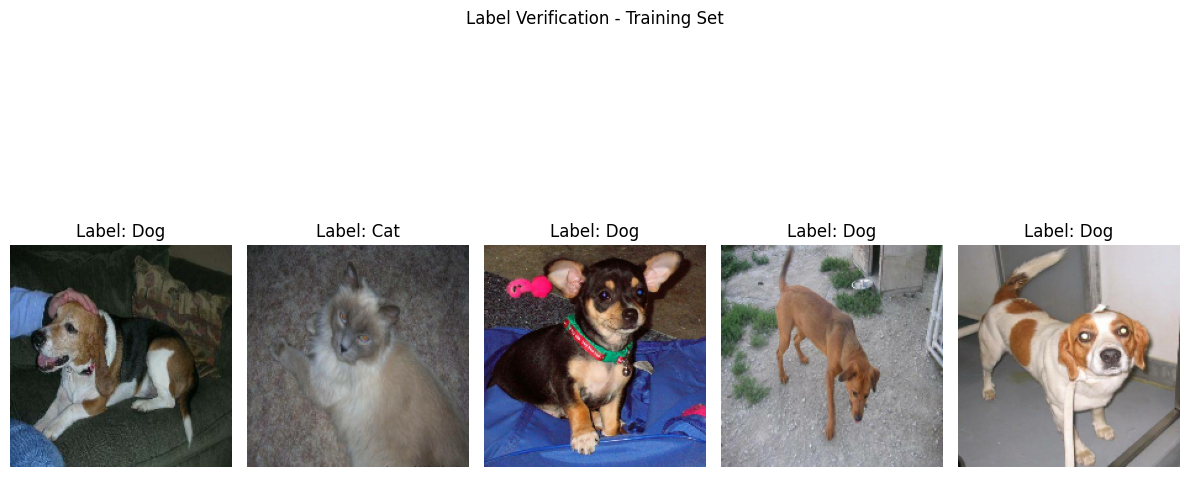

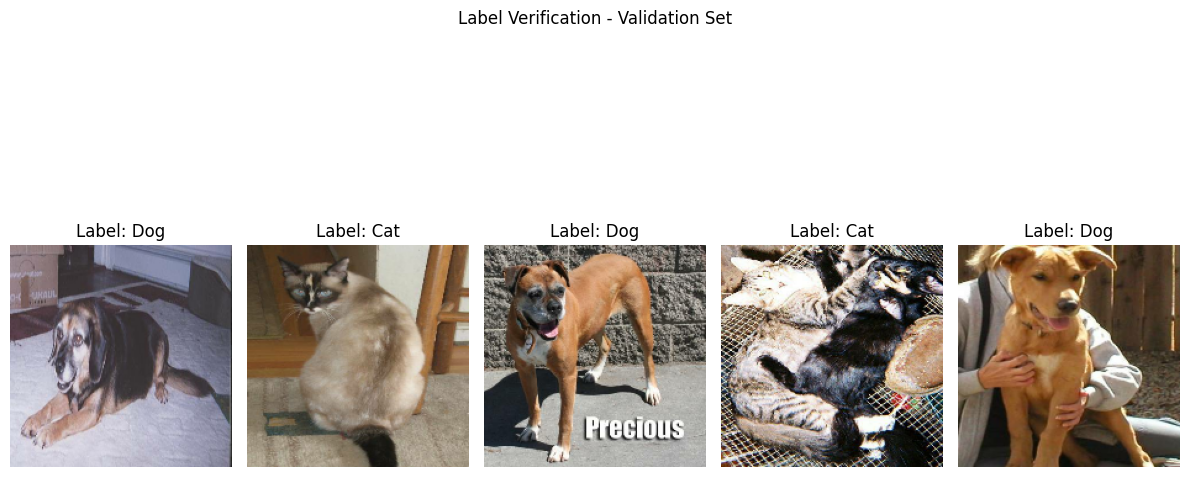

In [ ]:
# Dataset Labels Verification
def verify_labels(dataset, title, n=5):
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Label Verification - {title}', y=1.05)  # This will add  a title above the plots
    
    # Take a single batch from the dataset
    for images, labels in dataset.take(1):

        # Loop through the first 'n' images in the batch
        for i in range(min(n, len(images))):
            # Arrange images in a single row
            ax = plt.subplot(1, n, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            # Show corresponding label
            plt.title(f"Label: {'Dog' if labels[i] else 'Cat'}")
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

verify_labels(train_dataset, "Training Set")
verify_labels(validation_dataset, "Validation Set")

### **Train two networks (use callbacks to save the best model version)**

1. CNN Model Architecture for Binary Classification

In [13]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Compiling the CNN Model**

In [20]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [21]:
callbacks = [
     keras.callbacks.ModelCheckpoint(
         filepath="./models/convnet.keras",
         save_best_only=True,
         monitor="val_loss")
 ]
history = model.fit(
     train_dataset,
     epochs=30,
     validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30


63/63 [==============================] - 150s 2s/step - loss: 0.6975 - accuracy: 0.5025 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 131s 2s/step - loss: 0.6922 - accuracy: 0.5370 - val_loss: 0.7001 - val_accuracy: 0.5020
Epoch 3/30
63/63 [==============================] - 126s 2s/step - loss: 0.6797 - accuracy: 0.5790 - val_loss: 0.6442 - val_accuracy: 0.6290
Epoch 4/30
63/63 [==============================] - 129s 2s/step - loss: 0.6456 - accuracy: 0.6350 - val_loss: 0.6274 - val_accuracy: 0.6440
Epoch 5/30
63/63 [==============================] - 127s 2s/step - loss: 0.6165 - accuracy: 0.6755 - val_loss: 0.6781 - val_accuracy: 0.6150
Epoch 6/30
63/63 [==============================] - 139s 2s/step - loss: 0.5647 - accuracy: 0.7085 - val_loss: 0.5961 - val_accuracy: 0.6670
Epoch 7/30
63/63 [==============================] - 123s 2s/step - loss: 0.5237 - accuracy: 0.7500 - val_loss: 0.8759 - val_accuracy: 0.6220
Epoch 8/30
63/63 [======

Epoch 9 gave the least val- loss of: 0.5494 and there for was the best model and that was the model we saved 

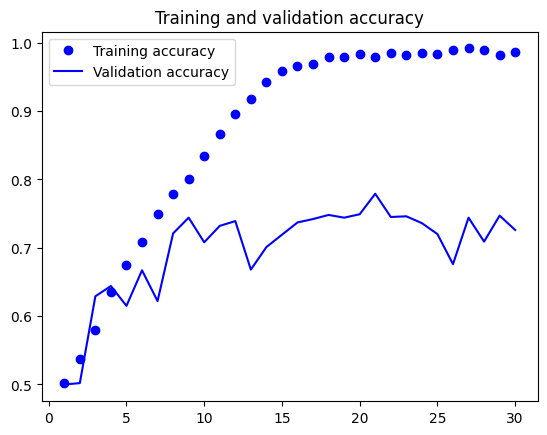

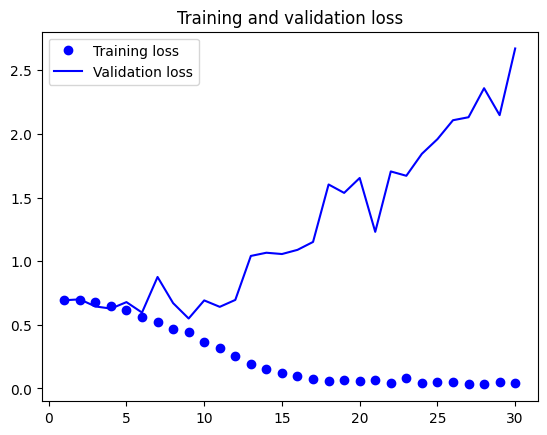

In [22]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### **Loss Metrics**  
- **Training Loss**: Decreases sharply from ~0.5 to near 0.0, indicating effective learning on training data.  
- **Validation Loss**: Starts higher (~0.8), decreases then started increasing above training loss, suggesting  overfitting.  

#### **Accuracy Metrics**  
- **Training Accuracy**: Rises from ~0.5 to ~0.9, showing strong performance on training data.  
- **Validation Accuracy**: Improves from ~0.6 but levels off  below training accuracy.  

### **Conculsion**  
The model learns well on training data but struggles to generalize to validation data,  due to overfitting after the 9th epoch 

In [23]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [24]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [25]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Custom Top Layers for VGG16  Learning Model**

In [26]:
inputs = keras.Input(shape=(180, 180, 3))
x = conv_base(inputs)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [27]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_1 (Dense)             (None, 256)               3277056   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 17,992,001
Trainable params: 3,277,313
Non-tr

In [28]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/VGG16_Model2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30


63/63 [==============================] - 476s 8s/step - loss: 32.2198 - accuracy: 0.8905 - val_loss: 6.9777 - val_accuracy: 0.9500
Epoch 2/30
63/63 [==============================] - 473s 8s/step - loss: 5.5860 - accuracy: 0.9640 - val_loss: 7.4344 - val_accuracy: 0.9490
Epoch 3/30
63/63 [==============================] - 475s 8s/step - loss: 3.7744 - accuracy: 0.9770 - val_loss: 8.6808 - val_accuracy: 0.9540
Epoch 4/30
63/63 [==============================] - 476s 8s/step - loss: 2.4688 - accuracy: 0.9840 - val_loss: 33.7773 - val_accuracy: 0.8930
Epoch 5/30
63/63 [==============================] - 475s 8s/step - loss: 1.8654 - accuracy: 0.9860 - val_loss: 13.3006 - val_accuracy: 0.9350
Epoch 6/30
63/63 [==============================] - 485s 8s/step - loss: 0.9816 - accuracy: 0.9905 - val_loss: 8.8474 - val_accuracy: 0.9580
Epoch 7/30
63/63 [==============================] - 487s 8s/step - loss: 0.8224 - accuracy: 0.9930 - val_loss: 11.1277 - val_accuracy: 0.9490
Epoch 8/30
63/63 [==

Epoch 1 gave the least val- loss of: 6.9777  and there for was the best model and that was the model we saved 

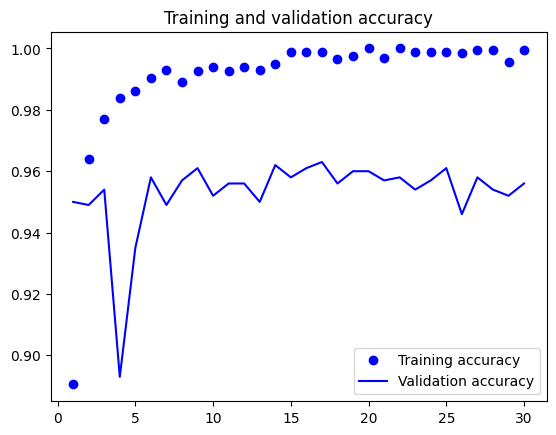

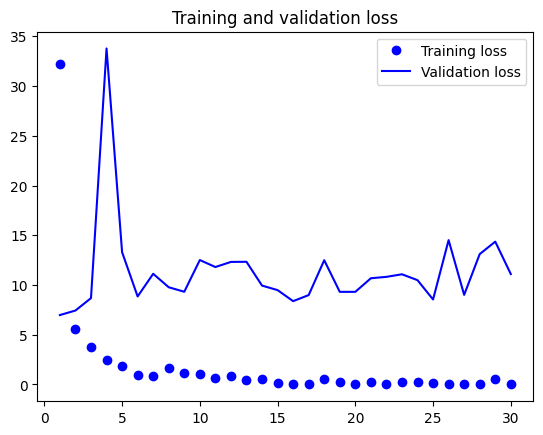

In [29]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### **Model Performance Summary**  

- **Training Accuracy:** Reaches near-perfect levels (~98-99%) by epoch 30.  
- **Validation Accuracy:** Peaks around 75-80% but stagnates, showing limited generalization.  
- **Training Loss:** Drops sharply to near zero, indicating strong memorization of training data.  
- **Validation Loss:** Rises significantly after initial improvement, confirming very bad overfitting.  

**InConculsion:** The model overfits .It performs exceptionally on training data but poorly on unseen validation data.

### **Explore the relative performance of the models**

 **Load the best CNN model**

In [ ]:
best_custom_model = keras.models.load_model("./models/convnet.keras")

**Load the best VGG16 model**

In [ ]:

best_vgg_model = keras.models.load_model("./models/VGG16_Model2.keras")

**Accuracy**

In [78]:
# Accuracy for VGG model

# Evaluate model performance on test dataset and returns loss accuracy metric
test_loss, test_acc = best_vgg_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 419s 7s/step - loss: 7.9301 - accuracy: 0.9545
Test accuracy: 0.955


In [ ]:
# Accuracy for Cnn model

# Evaluate model performance on test dataset and returns loss accuracy metric
test_loss, test_acc = best_custom_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 24s 376ms/step - loss: 0.5801 - accuracy: 0.7070
Test accuracy: 0.707


**Conculsion:** CNN achieved a test accuracy of 70.7% with a loss of 0.5801, showing consistent performance between training and testing phases. In contrast, the VGG16 model demonstrated significantly better performance, reaching a test accuracy of 95.5% despite a higher loss value of 7.9301. This suggests that while VGG16's loss metric appears elevated, its classification accuracy remains robust, highlighting its effectiveness for this task.

**Get predictions and true labels**

In [ ]:
# Get predictions and true labels for VGG model
vgg_true_labels = [] #  store actual labels from test dataset
vgg_pred_probs = [] #  store model's predicted probabilities

for images, labels in test_dataset:
    # Extract and store true labels for this batch 
    vgg_true_labels.extend(labels.numpy())
    vgg_pred_probs.extend(best_vgg_model.predict(images, verbose=0).flatten())

# Convert probabilities to binary predictions using 0.5 decision threshold
vgg_pred_labels = [1 if prob > 0.5 else 0 for prob in vgg_pred_probs]

In [ ]:
# Get predictions and true labels
custom_true_labels = [] # store actual labels from test dataset
custom_pred_probs = [] #  store model's predicted probabilities

for images, labels in test_dataset:
    # Extract and store true labels for this batch 
    custom_true_labels.extend(labels.numpy())
    custom_pred_probs.extend(best_custom_model.predict(images, verbose=0).flatten())

# Convert probabilities to binary predictions using 0.5 decision threshold
custom_pred_labels = [1 if prob > 0.5 else 0 for prob in custom_pred_probs]


**Confusion Matrix**

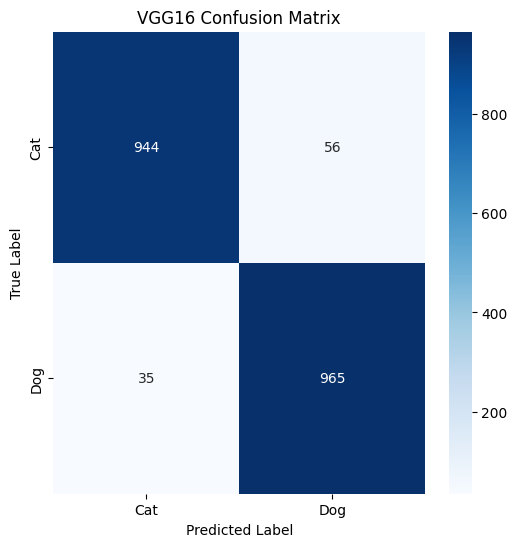

In [79]:
# Confusion Matrix for VGG Model 
vgg_cm = confusion_matrix(vgg_true_labels, vgg_pred_labels) # True ground truth labels and model's predicted labels 
plt.figure(figsize=(6, 6))
sns.heatmap(vgg_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat', 'Dog'], 
            yticklabels=['Cat', 'Dog'])
plt.title('VGG16 Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

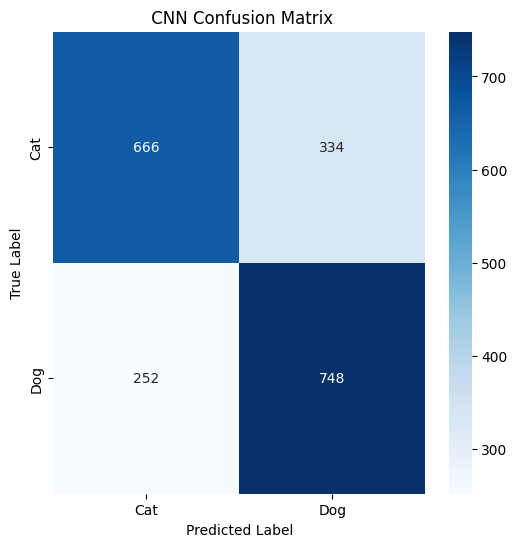

In [85]:
# Confusion Matrix for CNN model
custom_cm = confusion_matrix(custom_true_labels, custom_pred_labels)  # True ground truth labels and model's predicted labels 
plt.figure(figsize=(6, 6))
sns.heatmap(custom_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat', 'Dog'], 
            yticklabels=['Cat', 'Dog'])
plt.title(' CNN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


**Conculsion:** For CNN, the confusion matrix revealed 666 correct predictions for the Cat class and 748 for the Dog class. The VGG16 model, however, showed near-perfect classification, with 944 correct predictions for Cat and 965 for Dog. This stark difference underscores VGG16's superior ability to distinguish between the two classes.

**Precision, Recall, F1-Score**

In [ ]:
# Precision, Recall, F1-Score for VGG model
print("\nVGG16 Classification Report:")
print(classification_report(vgg_true_labels, vgg_pred_labels, target_names=['Cat', 'Dog']))


VGG16 Classification Report:
              precision    recall  f1-score   support

         Cat       0.96      0.94      0.95      1000
         Dog       0.95      0.96      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



In [84]:
# Precision, Recall, F1-Score for cnn model
print("\n CNN Classification Report:")
print(classification_report(custom_true_labels, custom_pred_labels, target_names=['Cat', 'Dog']))



 CNN Classification Report:
              precision    recall  f1-score   support

         Cat       0.73      0.67      0.69      1000
         Dog       0.69      0.75      0.72      1000

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.71      0.71      0.71      2000



**Conculsion:** CNN exhibited moderate precision and recall scores, with 0.73 precision and 0.67 recall for Cats, and 0.69 precision and 0.75 recall for Dogs. These results indicate a balanced but limited performance. On the other hand, VGG16 achieved exceptional precision and recall, scoring 0.96 precision and 0.94 recall for Cats, and 0.95 precision and 0.96 recall for Dogs. These near-perfect metrics demonstrate VGG16's reliability in minimizing false positives and negatives.

**Precision-Recall Curve for**

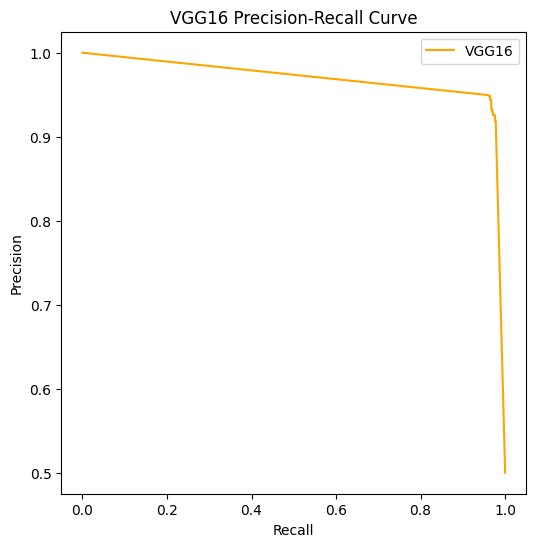

In [62]:

# Precision-Recall Curve for VGG Model 
vgg_precision_curve, vgg_recall_curve, _ = precision_recall_curve(vgg_true_labels, vgg_pred_probs)

plt.figure(figsize=(6, 6))
plt.plot(vgg_recall_curve, vgg_precision_curve, label='VGG16', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('VGG16 Precision-Recall Curve')
plt.legend()
plt.show()

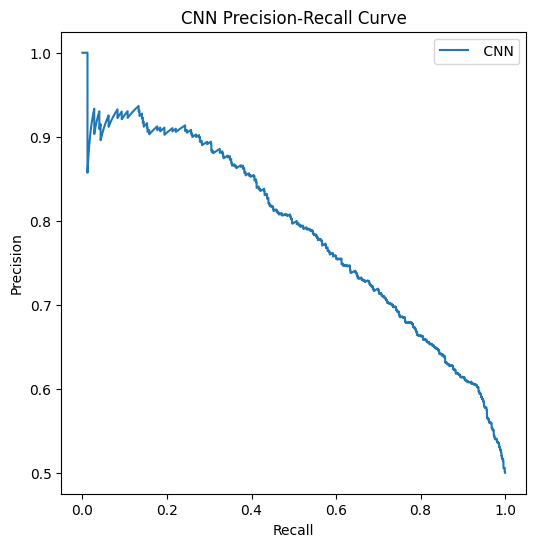

In [83]:

# Precision-Recall Curve for CNN model 
custom_precision_curve, custom_recall_curve, _ = precision_recall_curve(custom_true_labels, custom_pred_probs)

plt.figure(figsize=(6, 6))
plt.plot(custom_recall_curve, custom_precision_curve, label=' CNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('CNN Precision-Recall Curve')
plt.legend()
plt.show()


**Conculsion**:VGG16 demonstrates consistently high precision across all recall levels, maintaining robust performance even at higher recall values between 0.8 and 1.0, which indicates its strong ability to balance precision and recall effectively. In contrast,CNN exhibits a more pronounced decline in precision as recall increases. CNN's precision drops below 0.8 at moderate recall levels, suggesting limitations in maintaining high-confidence predictions compared to VGG16.

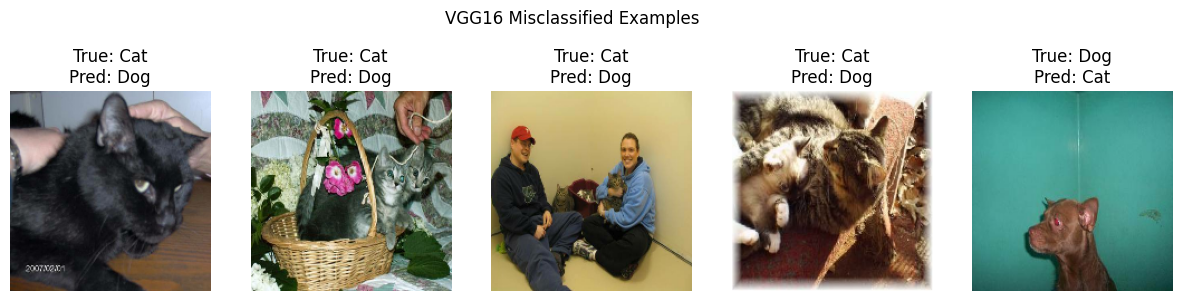

In [ ]:
#Misclassified Examples using VGG model
def show_vgg_misclassified(num_examples=5):
    plt.figure(figsize=(15, 3))
    plt.suptitle('VGG16 Misclassified Examples', y=1.1)
    count = 0
    
    for images, labels in test_dataset:
        preds = best_vgg_model.predict(images, verbose=0)
        pred_labels = (preds > 0.5).astype(int).flatten()
        
        for i in range(len(images)):
            if pred_labels[i] != labels[i] and count < num_examples:
                ax = plt.subplot(1, num_examples, count + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(f"True: {'Dog' if labels[i] else 'Cat'}\nPred: {'Dog' if pred_labels[i] else 'Cat'}")
                plt.axis("off")
                count += 1
                
        if count >= num_examples:
            break

show_vgg_misclassified()

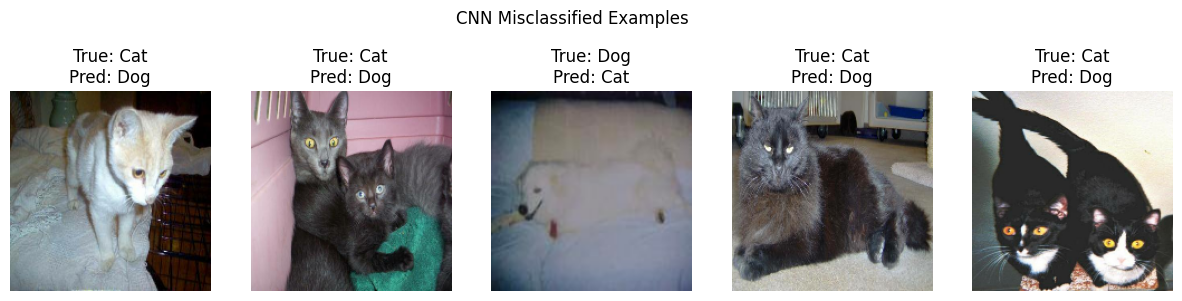

In [81]:

#  Misclassified Examples for Cnn model
def show_custom_misclassified(num_examples=5):
    plt.figure(figsize=(15, 3))
    plt.suptitle('CNN Misclassified Examples', y=1.1)
    count = 0
    
    for images, labels in test_dataset:
        preds = best_custom_model.predict(images, verbose=0)
        pred_labels = (preds > 0.5).astype(int).flatten()
        
        for i in range(len(images)):
            if pred_labels[i] != labels[i] and count < num_examples:
                ax = plt.subplot(1, num_examples, count + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(f"True: {'Dog' if labels[i] else 'Cat'}\nPred: {'Dog' if pred_labels[i] else 'Cat'}")
                plt.axis("off")
                count += 1
                
        if count >= num_examples:
            break

show_custom_misclassified()

**Recommendations and Conclusion**


**Conclusion**  

The evaluation demonstrates that the VGG16 model significantly outperforms the  CNN, achieving 95.5% accuracy compared to 70.7%, with near-perfect precision and recall. While VGG16 requires more computational resources, its superior performance makes it the clear choice for high-accuracy applications like this task . The  CNN could be improved , but for this task, VGG16 is the most effective solution.Ultimately, VGG16 delivers the best results for this classification task.